<a href="https://colab.research.google.com/github/monya-9/deep-learning-practice/blob/main/07_dropout_mlp_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dropout 적용 전후 성능 비교 (MLP, CNN)

In [ ]:
# ===========================
# 1. 라이브러리 임포트
# ===========================
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# ===========================
# 2. 데이터셋 준비 (CIFAR-10)
# ===========================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 43.5MB/s]


- CIFAR-10 32×32 컬러 이미지 사용
- Transform
  - ToTensor(): 이미지를 PyTorch Tensor로 변환
  - Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)): 픽셀값을 [-1, 1] 범위로 정규화
- DataLoader
  - 배치 단위 학습 가능(batch_size=128)
  - train loader는 shuffle=True, test loader는 shuffle=False

In [ ]:
# ===========================
# 3. 모델 정의 (MLP, CNN, Dropout 적용 O/X)
# ===========================
class MLP(nn.Module):
    def __init__(self, use_dropout=False):
        super(MLP, self).__init__()
        if use_dropout:
            self.fc = nn.Sequential(
                nn.Flatten(),
                nn.Linear(32*32*3, 512), nn.ReLU(), nn.Dropout(0.5),
                nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.5),
                nn.Linear(256, 10)
            )
        else:
            self.fc = nn.Sequential(
                nn.Flatten(),
                nn.Linear(32*32*3, 512), nn.ReLU(),
                nn.Linear(512, 256), nn.ReLU(),
                nn.Linear(256, 10)
            )
    def forward(self, x):
        return self.fc(x)

class CNN(nn.Module):
    def __init__(self, use_dropout=False):
        super(CNN, self).__init__()
        if use_dropout:
            self.conv = nn.Sequential(
                nn.Conv2d(3, 32, 3, 1), nn.ReLU(),
                nn.Conv2d(32, 64, 3, 1), nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Dropout(0.25)
            )
            self.fc = nn.Sequential(
                nn.Flatten(),
                nn.Linear(64*14*14, 256), nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(256, 10)
            )
        else:
            self.conv = nn.Sequential(
                nn.Conv2d(3, 32, 3, 1), nn.ReLU(),
                nn.Conv2d(32, 64, 3, 1), nn.ReLU(),
                nn.MaxPool2d(2)
            )
            self.fc = nn.Sequential(
                nn.Flatten(),
                nn.Linear(64*14*14, 256), nn.ReLU(),
                nn.Linear(256, 10)
            )
    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)

MLP
- 이미지 Flatten -> FC 레이어 3개
  - Dropout=True -> 각 FC 사이에 0.5 적용

CNN
- Conv -> ReLU -> Conv -> ReLU -> MaxPool -> FC
  - Dropout=True -> Conv 끝 0.25, FC 중간 0.5

Dropout 적용 전 후 비교 가능

In [ ]:
# ===========================
# 4. 학습 & 평가 함수
# ===========================
def train_and_evaluate_with_history(model, epochs=5):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_acc_history = []
    test_acc_history = []

    for epoch in range(epochs):
        model.train()
        correct_train, total_train = 0, 0
        for data, target in trainloader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            _, pred = torch.max(output, 1)
            correct_train += (pred == target).sum().item()
            total_train += target.size(0)

        train_acc = correct_train / total_train
        train_acc_history.append(train_acc)

        # 테스트 정확도
        model.eval()
        correct_test, total_test = 0, 0
        with torch.no_grad():
            for data, target in testloader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                _, pred = torch.max(output, 1)
                correct_test += (pred == target).sum().item()
                total_test += target.size(0)
        test_acc = correct_test / total_test
        test_acc_history.append(test_acc)

    return train_acc_history, test_acc_history

- Adam optimizer, CrossEntropyLoss
- epochs=5, train & evaluation 포함
- GPU 사용 가능

In [ ]:
# ===========================
# 5. 네 가지 경우 비교 실행
# ===========================
history_results = {}

models = {
    "MLP_no_dropout": MLP(use_dropout=False),
    "MLP_with_dropout": MLP(use_dropout=True),
    "CNN_no_dropout": CNN(use_dropout=False),
    "CNN_with_dropout": CNN(use_dropout=True)
}

for name, model in models.items():
    train_hist, test_hist = train_and_evaluate_with_history(model, epochs=5)
    history_results[name] = {"train": train_hist, "test": test_hist}

- MLP_no_dropout

- MLP_with_dropout

- CNN_no_dropout

- CNN_with_dropout

각 모델을 학습 후 테스트셋 정확도 계산

In [ ]:
# ===========================
# 6. 결과 출력
# ===========================
for k, v in results.items():
    print(f"{k}: {v*100:.2f}%")

MLP_no_dropout: 52.94%
MLP_with_dropout: 48.99%
CNN_no_dropout: 70.95%
CNN_with_dropout: 70.44%


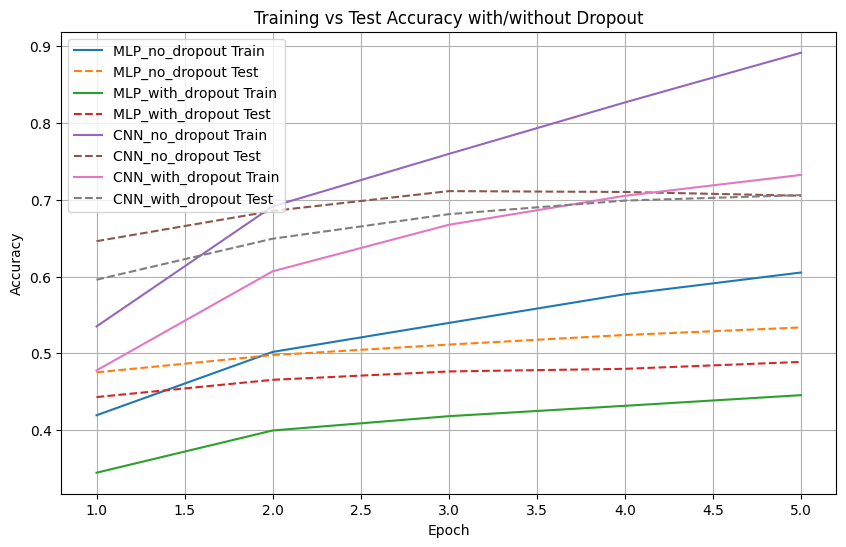

In [ ]:
# ===========================
# 7. 시각화
# ===========================
plt.figure(figsize=(10,6))
epochs = range(1, 6)

for name, hist in history_results.items():
    plt.plot(epochs, hist['train'], label=f"{name} Train")
    plt.plot(epochs, hist['test'], '--', label=f"{name} Test")  # 점선: 테스트 정확도

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Test Accuracy with/without Dropout")
plt.legend()
plt.grid(True)
plt.show()

## Dropout 적용 전후 MLP/CNN 정확도 비교표
| 모델  | Dropout | 테스트 정확도 |
| --- | ------- | ------- |
| MLP | 없음      | 52.94%  |
| MLP | 적용      | 48.99%  |
| CNN | 없음      | 70.95%  |
| CNN | 적용      | 70.44%  |
